In [1]:
# all import statements needed for the project, for example:
import math
import bs4
import requests
import sqlalchemy as db
import pandas as pd 
import numpy as np
import datetime as dt
import statsmodels.api as sm #统计
from statsmodels.tsa.stattools import adfuller #ADF检验
import matplotlib as mpl #画图
import matplotlib.pyplot as plt
mpl.rcParams['font.family']='serif'
plt.style.use('seaborn') 
import os #地址

C:\Users\29311\AppData\Local\Temp\ipykernel_16724\1396338694.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
cd

C:\Users\29311


In [3]:
os.chdir('Desktop/CU/E4501/PPP2') 

In [4]:
# any general notebook setup, like log formatting

In [5]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 2: Storing Cleaned Data

1. use SQLAlchemy, create a SQLite database to load in preprocessed datasets;
2. create and populate 4 tables: one for sampled datasets of Yellow Taxi trips, one for Uber trips, one for hourly weather information, and one for daily weather information. 
3. create a schema.sql file that defines each table’s schema. 

In [6]:
uber_data=pd.read_csv('uber.csv').iloc[:,1:]
hour=pd.read_csv('hour.csv').iloc[:,1:]
daily=pd.read_csv('daily.csv').iloc[:,1:]
taxi_data=pd.read_csv('taxi_data.csv').iloc[:,1:]

In [7]:
taxi_data['pickup_datetime']=pd.to_datetime(taxi_data['pickup_datetime'])
taxi_data['dropoff_datetime']=pd.to_datetime(taxi_data['dropoff_datetime'])

In [8]:
taxi_data

,year,month,hour,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance,tip,passenger_count
0,2022,1,12,2022-01-08 12:47:26,2022-01-08 12:50:59,40.717773,-74.007880,40.723888,-74.001538,0.60,1.00,1.0
1,2022,1,19,2022-01-13 19:35:17,2022-01-13 19:52:53,40.717773,-74.007880,40.768615,-73.965635,5.08,4.26,1.0
2,2022,1,19,2022-01-14 19:29:49,2022-01-14 20:10:12,40.646985,-73.786533,40.727620,-73.985937,17.91,14.95,1.0
3,2022,1,19,2022-01-25 19:59:48,2022-01-25 20:08:39,40.720889,-73.996919,40.714733,-73.983025,1.10,2.00,2.0
4,2022,1,16,2022-01-05 16:09:54,2022-01-05 16:16:09,40.723888,-74.001538,40.732579,-73.994305,1.10,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
202025,2009,12,20,2009-12-23 20:09:00,2009-12-23 20:11:00,40.763593,-73.972853,40.760775,-73.967578,0.37,1.00,1.0
202026,2009,12,19,2009-12-15 19:13:00,2009-12-15 19:16:00,40.742840,-73.980168,40.748047,-73.981568,0.51,0.00,1.0
202027,2009,12,22,2009-12-28 22:52:00,2009-12-28 23:18:00,40.644810,-73.781915,40.664808,-73.939545,11.98,0.00,2.0
202028,2009,12,17,2009-12-09 17:37:00,2009-12-09 17:49:00,40.753100,-73.971938,40.770513,-73.947885,2.22,0.00,5.0


In [9]:
engine = db.create_engine(DATABASE_URL)

In [10]:
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY,
    date TEXT,
    hourlyprecipitation FLOAT,
    sustainedwindspeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY,
    date TEXT,
    dailyaveragewindspeed FLOAT,
    dailypeakwindspeed FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi (
    id INTEGER PRIMARY KEY,
    month INTEGER,
    hour INTEGER,
    year INTEGER,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    pickup_latitude FLOAT, 
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT,
    distance FLOAT,
    tip FLOAT,
    passenger_count INTEGER
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber (
    id INTEGER PRIMARY KEY,
    fare_amount FLOAT,
    pickup_datetime TEXT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,  
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    passenger_count INTEGER,
    date TEXT,
    week INTEGER,
    distance FLOAT
);
"""
 

In [11]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [12]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database

1. define function to insert data from dataframe to SQL database
2. use dictionary to store data and data name
3. add data to database

In [13]:
def write_dataframes_to_table(table_to_df_dict):
    for k,v in map_table_name_to_dataframe.items():
        v.to_sql(k,con=engine,if_exists='append',index_label='id')  

In [14]:
map_table_name_to_dataframe = {
    "taxi": taxi_data,
    "uber": uber_data,
    "hourly_weather": hour,
    "daily_weather": daily,
}

In [15]:
write_dataframes_to_table(map_table_name_to_dataframe)

In [16]:
map_table_name_to_dataframe

{'taxi':         year  month  hour     pickup_datetime    dropoff_datetime  \
 0       2022      1    12 2022-01-08 12:47:26 2022-01-08 12:50:59   
 1       2022      1    19 2022-01-13 19:35:17 2022-01-13 19:52:53   
 2       2022      1    19 2022-01-14 19:29:49 2022-01-14 20:10:12   
 3       2022      1    19 2022-01-25 19:59:48 2022-01-25 20:08:39   
 4       2022      1    16 2022-01-05 16:09:54 2022-01-05 16:16:09   
 ...      ...    ...   ...                 ...                 ...   
 202025  2009     12    20 2009-12-23 20:09:00 2009-12-23 20:11:00   
 202026  2009     12    19 2009-12-15 19:13:00 2009-12-15 19:16:00   
 202027  2009     12    22 2009-12-28 22:52:00 2009-12-28 23:18:00   
 202028  2009     12    17 2009-12-09 17:37:00 2009-12-09 17:49:00   
 202029  2009     12    18 2009-12-30 18:06:00 2009-12-30 18:20:18   
 
         pickup_latitude  pickup_longitude  dropoff_latitude  \
 0             40.717773        -74.007880         40.723888   
 1             40.7177

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [√] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [√] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [√] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [17]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

### Query N

1. define a SQL query for each of the following questions - one query per question. 
2. Save each query as a .sql file, naming it something illustrative of what the query is for, e.g. top_10_hottest_days.sql.

$Question \ 1$

$\text{For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.}$

In [18]:
QUERY_1="""
SELECT hour,COUNT(hour) FROM taxi
WHERE pickup_datetime BETWEEN "2009-01-01" AND "2015-07-01"
GROUP BY hour
ORDER BY COUNT(hour) DESC

"""

In [19]:
engine.execute(QUERY_1).fetchall()

[(19, 6024),
 (20, 5698),
 (18, 5648),
 (21, 5453),
 (22, 5178),
 (14, 4872),
 (12, 4729),
 (17, 4698),
 (23, 4581),
 (15, 4542),
 (13, 4538),
 (8, 4446),
 (11, 4385),
 (9, 4380),
 (10, 4176),
 (16, 4040),
 (0, 3763),
 (7, 3515),
 (1, 2869),
 (2, 2002),
 (6, 1990),
 (3, 1561),
 (4, 1099),
 (5, 947)]

$Question \ 2$

$\text{From 01-2009 to 06-2015, what day of the week was the most popular to take an uber? The result should have 7 bins.}$

In [20]:
QUERY_2 = """
SELECT week, COUNT(week) FROM (SELECT DISTINCT week,date FROM uber
WHERE date BETWEEN "2009-01-01" AND "2015-07-01" )
GROUP BY week
ORDER BY COUNT(week) DESC
"""

In [21]:
engine.execute(QUERY_2).fetchall()

[(7, 339), (6, 339), (5, 339), (4, 339), (2, 339), (1, 339), (3, 338)]

In [22]:
write_query_to_file(QUERY_2, "popular_day_of_week_uber.sql")

$ Question \ 3$

$\text{What is the 95% percentile of distance traveled for all hired trips during July 2013?}$

In [23]:
QUERY_3="""
WITH two AS 
(SELECT pickup_datetime,distance FROM uber
WHERE "2013-06-30T00:00"< pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
UNION ALL
SELECT pickup_datetime,distance FROM taxi
WHERE "2013-06-30T00:00"<pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00')

SELECT distance AS '95%distance'FROM two
ORDER BY distance 
LIMIT 1
OFFSET (SELECT COUNT(*)
        FROM two) * 95 / 100 - 1 ;
"""

In [24]:
engine.execute(QUERY_3).fetchall()

[(10.219292783094737,)]

In [25]:
write_query_to_file(QUERY_3, "95%percentile_distance.sql")

$Question \ 4$

$\text{What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?}$

In [26]:
QUERY_4 = """
WITH RECURSIVE ride AS ( 
SELECT id,pickup_datetime,distance
FROM taxi
WHERE "2009-01-1"< pickup_datetime AND pickup_datetime < '2010-01-01'
UNION ALL
SELECT id,pickup_datetime, distance
FROM uber
WHERE "2009-01-1"< pickup_datetime AND pickup_datetime < '2010-01-01'
)

SELECT DATE(pickup_datetime),COUNT(id),avg(distance) FROM ride
GROUP BY DATE(pickup_datetime)
ORDER BY COUNT(id) DESC
LIMIT 10
"""

In [27]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 189, 2.6063858821542243),
 ('2009-10-23', 172, 2.608186935880316),
 ('2009-04-18', 165, 3.2159688165794567),
 ('2009-08-14', 164, 3.384805254622663),
 ('2009-02-20', 164, 2.806243621671769),
 ('2009-12-05', 162, 2.71374114068847),
 ('2009-11-05', 160, 2.902796690455225),
 ('2009-03-19', 160, 3.086773537826006),
 ('2009-07-09', 158, 3.4255733465502183),
 ('2009-07-23', 157, 3.407106718976077)]

$Question \ 5$

$\text{Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?}$

In [28]:
#peak wind speed
QUERY_5 = """
WITH ride AS
(SELECT DATE(pickup_datetime) AS date, count(pickup_datetime) AS count from (SELECT pickup_datetime FROM uber
WHERE "2013-12-31T00:00"< pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00'
UNION ALL
SELECT pickup_datetime FROM taxi
WHERE "2013-12-31T00:00"<pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00')
GROUP BY DATE(pickup_datetime))

SELECT * FROM(SELECT DATE(daily_weather.date) AS date, daily_weather.dailyaveragewindspeed, 
daily_weather.dailypeakwindspeed, ride.count
FROM daily_weather 
LEFT OUTER JOIN ride 
ON DATE(daily_weather.date)=DATE(ride.date)
ORDER BY daily_weather.dailypeakwindspeed DESC
LIMIT 10
)
"""

In [29]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.1, 40.0, 157),
 ('2014-12-07', 11.8, 40.0, 111),
 ('2014-02-13', 12.6, 39.0, 107),
 ('2014-02-27', 8.4, 39.0, 151),
 ('2014-01-07', 13.1, 38.0, 122),
 ('2014-02-14', 10.4, 38.0, 114),
 ('2014-03-26', 11.9, 38.0, 138),
 ('2014-04-05', 8.4, 36.0, 139),
 ('2014-04-23', 9.4, 36.0, 122),
 ('2014-11-02', 10.8, 36.0, 131)]

In [30]:
#average wind speed
QUERY_5 = """
WITH ride AS
(SELECT DATE(pickup_datetime) AS date, count(pickup_datetime) AS count from (SELECT pickup_datetime FROM uber
WHERE "2013-12-31T00:00"< pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00'
UNION ALL
SELECT pickup_datetime FROM taxi
WHERE "2013-12-31T00:00"<pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00')
GROUP BY DATE(pickup_datetime))

SELECT * FROM(SELECT DATE(daily_weather.date) AS date, daily_weather.dailyaveragewindspeed, 
daily_weather.dailypeakwindspeed, ride.count
FROM daily_weather 
LEFT OUTER JOIN ride 
ON DATE(daily_weather.date)=DATE(ride.date)
ORDER BY daily_weather.dailyaveragewindspeed DESC
LIMIT 10
)
"""

In [31]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.1, 40.0, 157),
 ('2014-01-07', 13.1, 38.0, 122),
 ('2014-02-13', 12.6, 39.0, 107),
 ('2014-01-02', 12.2, 28.0, 94),
 ('2014-03-26', 11.9, 38.0, 138),
 ('2014-12-07', 11.8, 40.0, 111),
 ('2014-12-08', 11.5, 29.0, 112),
 ('2014-03-29', 10.8, 35.0, 142),
 ('2014-11-02', 10.8, 36.0, 131),
 ('2014-01-03', 10.4, 29.0, 62)]

In [32]:
write_query_to_file(QUERY_5, "top10_windest_hiredtrips.sql")

$Question \ 6$

$\text{During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it,}$ 
$\text{how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?}$

In [33]:
QUERY_6 = """
WITH RECURSIVE ride AS ( 
SELECT COUNT(id),strftime ("%Y-%m-%d %H",pickup_datetime) AS Hour
FROM taxi
WHERE "2012-10-22"< pickup_datetime AND pickup_datetime < '2012-10-31'
UNION ALL
SELECT COUNT(id), strftime ("%Y-%m-%d %H",pickup_datetime) AS Hour
FROM uber
WHERE "2012-10-22"< pickup_datetime AND pickup_datetime < '2012-10-31'
GROUP BY Hour
ORDER BY Hour
)
Select * FROM ride
JOIN  (select strftime ("%Y-%m-%d %H",date) AS H ,hourlyprecipitation,sustainedwindspeed from hourly_weather) on Hour = H

"""

In [34]:
engine.execute(QUERY_6).fetchall()

[(2, '2012-10-22 00', '2012-10-22 00', 0.0, 13.0),
 (1, '2012-10-22 02', '2012-10-22 02', 0.0, 13.0),
 (1, '2012-10-22 03', '2012-10-22 03', 0.0, 13.0),
 (1, '2012-10-22 05', '2012-10-22 05', 0.0, 13.0),
 (3, '2012-10-22 06', '2012-10-22 06', 0.0, 13.0),
 (5, '2012-10-22 07', '2012-10-22 07', 0.0, 13.0),
 (1, '2012-10-22 08', '2012-10-22 08', 0.0, 13.0),
 (5, '2012-10-22 09', '2012-10-22 09', 0.0, 13.0),
 (3, '2012-10-22 10', '2012-10-22 10', 0.0, 13.0),
 (8, '2012-10-22 11', '2012-10-22 11', 0.0, 13.0),
 (5, '2012-10-22 12', '2012-10-22 12', 0.0, 13.0),
 (8, '2012-10-22 13', '2012-10-22 13', 0.0, 13.0),
 (1, '2012-10-22 14', '2012-10-22 14', 0.0, 13.0),
 (1, '2012-10-22 15', '2012-10-22 15', 0.0, 13.0),
 (6, '2012-10-22 16', '2012-10-22 16', 0.0, 13.0),
 (4, '2012-10-22 17', '2012-10-22 17', 0.0, 13.0),
 (8, '2012-10-22 18', '2012-10-22 18', 0.0, 13.0),
 (2, '2012-10-22 19', '2012-10-22 19', 0.0, 13.0),
 (4, '2012-10-22 20', '2012-10-22 20', 0.0, 13.0),
 (1, '2012-10-22 21', '2012-10-

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

In [92]:
LGA_BOX_COORDS=((40.765,-73.8893),(40.7864,-73.8512))
JFK_BOX_COORDS=((40.6211,-73.8232),(40.6648,-73.7484))
EWR_BOX_COORDS=((40.6704,-74.2151),(40.7114,-74.1132))
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

QUERY_LGA="""
WITH RECURSIVE ride AS ( 
    SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id, dropoff_longitude, dropoff_latitude FROM taxi
    WHERE  40.765<dropoff_latitude AND dropoff_latitude< 40.7864 AND -73.8893 <dropoff_longitude AND dropoff_longitude<-73.8512
    UNION ALL
    SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id,dropoff_longitude, dropoff_latitude FROM uber
    WHERE  40.765<dropoff_latitude AND dropoff_latitude< 40.7864 AND -73.8893 <dropoff_longitude AND dropoff_longitude<-73.8512
    )
SELECT Day,COUNT(id) FROM ride    
GROUP BY Day
ORDER BY COUNT(id) DESC
""" 
QUERY_JFK="""
WITH RECURSIVE ride AS ( 
    SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id, dropoff_longitude, dropoff_latitude 
    FROM taxi
    WHERE  40.6211 <dropoff_latitude AND dropoff_latitude< 40.6648 AND  -73.8232 <dropoff_longitude AND dropoff_longitude< -73.7484
    UNION ALL
    SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id,dropoff_longitude, dropoff_latitude 
    FROM uber
    WHERE  40.6211 <dropoff_latitude AND dropoff_latitude< 40.6648  AND  -73.8232 <dropoff_longitude AND dropoff_longitude< -73.7484
    )
SELECT Day,COUNT(id) FROM ride    
GROUP BY Day
ORDER BY COUNT(id) DESC
""" 
QUERY_EWR="""
WITH RECURSIVE ride AS ( 
    SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id, dropoff_longitude, dropoff_latitude FROM taxi
    WHERE 40.6704<dropoff_latitude AND dropoff_latitude< 40.7214 AND -74.2151 <dropoff_longitude AND dropoff_longitude<-74.1132
    UNION ALL
    SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id,dropoff_longitude, dropoff_latitude FROM uber
    WHERE 40.6704<dropoff_latitude AND dropoff_latitude< 40.7214 AND -74.2151 <dropoff_longitude AND dropoff_longitude<-74.1132
    )
SELECT Day,COUNT(id) FROM ride    
GROUP BY Day
ORDER BY COUNT(id) DESC
 """ 
LGA=pd.DataFrame(engine.execute(QUERY_LGA).fetchall())
LGA.replace([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thur","Fri","Sat","Sun"],inplace=True)
LGA_1=LGA[["Day","COUNT(id)"]].set_index("Day")

JFK=pd.DataFrame(engine.execute(QUERY_JFK).fetchall())
JFK.replace([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thur","Fri","Sat","Sun"],inplace=True)
JFK_1=JFK[["Day","COUNT(id)"]].set_index("Day")

EWR=pd.DataFrame(engine.execute(QUERY_EWR).fetchall())
EWR.replace([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thur","Fri","Sat","Sun"],inplace=True)
EWR_1=EWR[["Day","COUNT(id)"]].set_index("Day")

ALL=pd.concat([LGA_1,JFK_1,EWR_1],axis=1)
ALL.columns=["LGA","JFK","EWR"]

ALL

,LGA,JFK,EWR
Day,,,
Sat,853,491,89
Fri,820,532,95
Tue,721,469,85
Thur,704,456,93
Mon,659,501,107
Wed,613,388,75
Sun,424,416,58


<AxesSubplot: xlabel='Day'>

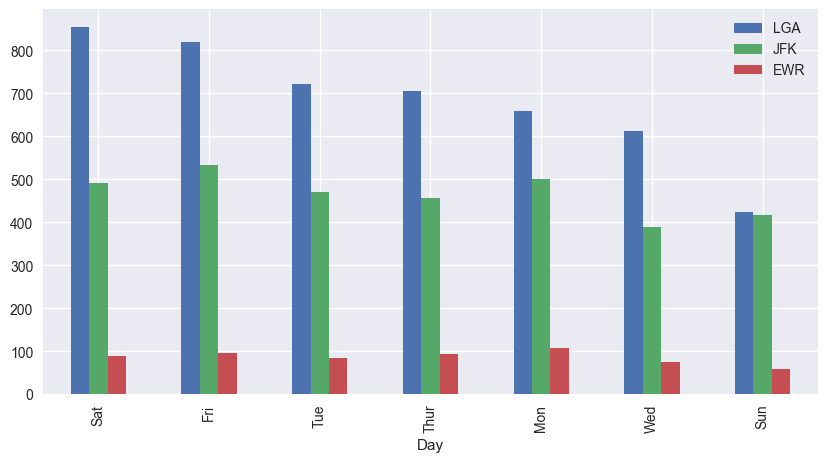

In [96]:
ALL.plot(kind='bar',figsize=(10,5))

<AxesSubplot: title={'center': 'LGA'}, ylabel='Day'>

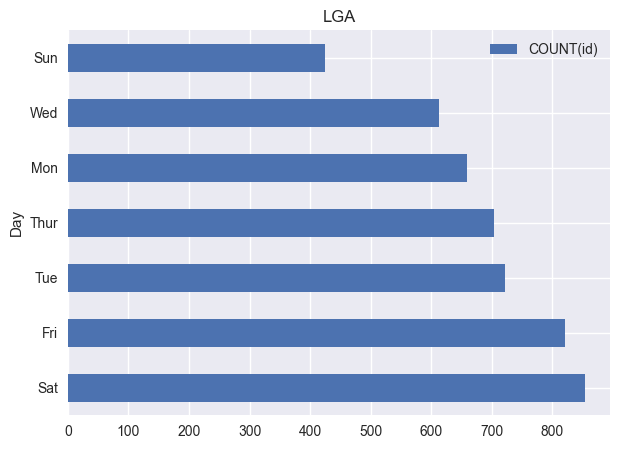

In [106]:
LGA_1.plot(kind='barh',title="LGA",figsize=(7,5))

<AxesSubplot: title={'center': 'JFK'}, ylabel='Day'>

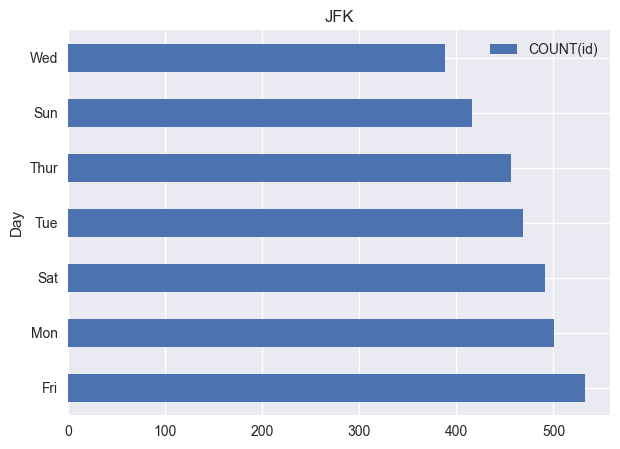

In [107]:
JFK_1.plot(kind='barh',title="JFK",figsize=(7,5))

<AxesSubplot: title={'center': 'EWR'}, ylabel='Day'>

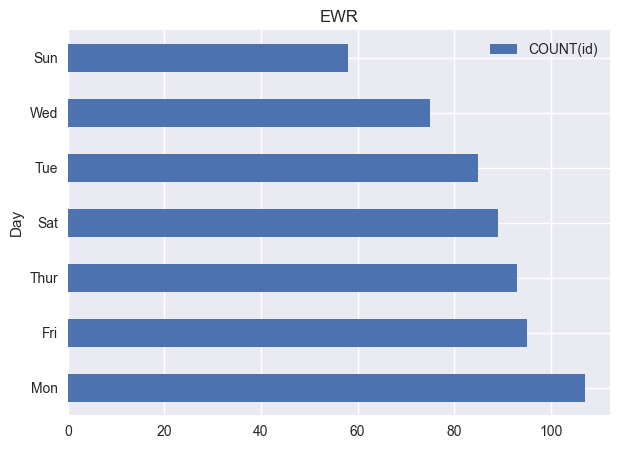

In [108]:
EWR_1.plot(kind='barh',title="EWR",figsize=(7,5))

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

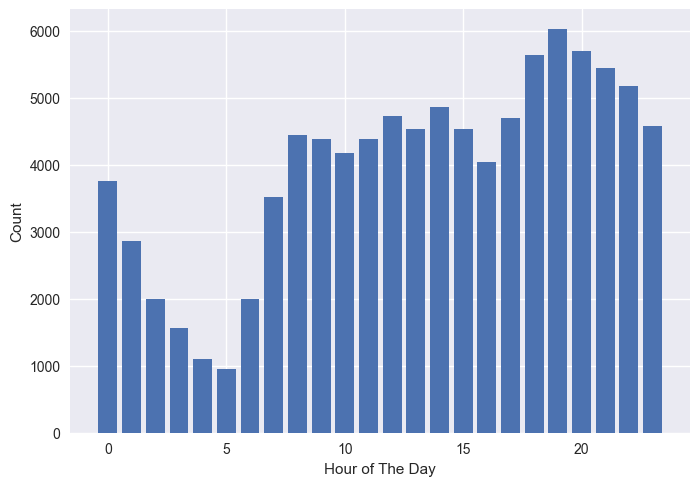

In [109]:
def get_data_for_visual_1():
    QUERY_1="""
    SELECT hour,COUNT(hour) FROM taxi
    WHERE pickup_datetime BETWEEN "2009-01-01" AND "2015-07-01"
    GROUP BY hour
    ORDER BY COUNT(hour) DESC

    """ 
    x=pd.DataFrame(engine.execute(QUERY_1).fetchall(),columns=["Hour","Count"])
    plt.bar(x["Hour"],x["Count"])
    plt.xlabel("Hour of The Day")
    plt.ylabel("Count")
    plt.show()

    #print(type(x),x)
get_data_for_visual_1()

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

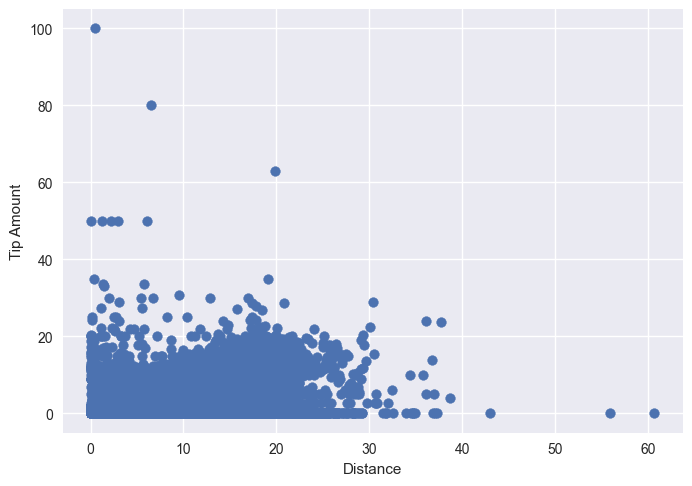

In [110]:
QUERY="""
SELECT tip, distance FROM taxi
WHERE tip>=0 AND distance >0
"""
x=pd.DataFrame(engine.execute(QUERY).fetchall())
plt.scatter(x["distance"],x["tip"])
plt.xlabel("Distance")
plt.ylabel("Tip Amount")
plt.show()

In [111]:
QUERY="""
SELECT count(id),tip, distance FROM taxi
WHERE tip>=0 AND distance >0
GROUP BY tip
"""
c=pd.DataFrame(engine.execute(QUERY).fetchall())
c

,count(id),tip,distance
0,86818,0.00,1.10
1,85,0.01,1.30
2,40,0.02,0.73
3,9,0.03,3.40
4,6,0.04,0.80
...,...,...,...
1486,2,35.00,0.37
1487,5,50.00,1.25
1488,1,63.00,19.85
1489,1,80.00,6.50


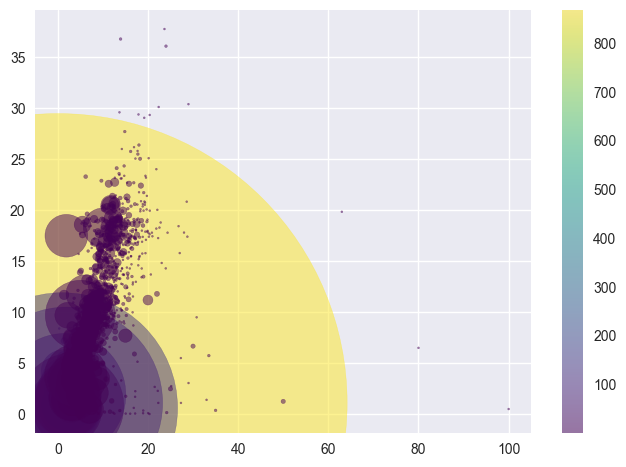

In [116]:
#plt.scatter(x["distance"],x["tip"])
#plt.xlabel("Distance")
#plt.ylabel("Tip Amount")
#plt.show()
x = c["tip"]
y = c["distance"]

# random values for colors (we'll learn more later on)
colors = 0.01*c["count(id)"]

# random sizes for the points being plotted
sizes =  2* c["count(id)"]

plt.scatter(x, y, c=colors, s=sizes, alpha=0.5, cmap='viridis')
plt.colorbar();